## Problem statement

Build a model to output a number representing how different the given input voices are.
the input will be 2 audio clips, the output should be 1 if the voices in the clips are same. 0 if they are different.

*Dataset*: UrbanSound_8k

In [1]:
# Import the libraries
import os
from pathlib import Path
import numpy as np
import pandas as pd
import itertools
import matplotlib.pyplot as plt
import librosa
import IPython.display as ipd
import cv2 as cv
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, auc
import tensorflow as tf
%matplotlib inline

In [2]:
print("Tensorflow version:", tf.__version__)

Tensorflow version: 2.12.0


In [3]:
!nvidia-smi -L

GPU 0: Tesla T4 (UUID: GPU-2b78febc-1394-e2a2-5e86-74d35f3c8fe6)


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
class Config:
    dataset_path = "/content/drive/MyDrive/UrbanSound8k/data"  # directory of dataset
    sampling_rate = 44100   # samples per second
    n_fft = 2048            # Samples in each frame for STFT
    hop_length = 512        # frame stride length
    mono = True             # single channel audio
    n_mfcc = 50             # No of MFCC features
    max_len = 132300        # shorter audios padded to this length
    max_frames = int(max_len/hop_length)+1   # maximum frames in mfcc (shorter will be padded with zeros upto this number)


### Utility functions

*Preprocessing utilities*

In [63]:
# Function to load audio data
def load_audio(path):
    signal, _ = librosa.load(path, sr=Config.sampling_rate, mono=Config.mono)
    # Normalize the signal
    signal = librosa.util.normalize(signal)
    return signal

# Generates White noise for signal.
def get_white_noise(signal, SNR=40) :
    RMS_s=np.sqrt(np.mean(signal**2))
    STD_n=np.sqrt(RMS_s**2/(pow(10,SNR/10)))
    noise=np.random.normal(0, STD_n, signal.shape[0])
    return noise

# Function to compute mfcc features
def get_mfcc(signal):
    mfcc = librosa.feature.mfcc(y=signal, n_fft=Config.n_fft, hop_length=Config.hop_length, n_mfcc=Config.n_mfcc)
    return np.transpose(mfcc)

# Function to trim a signal to shorter length
def pad_signal(signal):
    if len(signal) > Config.max_len:
        return signal[:Config.max_len]
    if len(signal) < Config.max_len:
        pad_width = Config.max_len - len(signal)
        padded_signal = np.pad(signal, (0, pad_width), "constant")
        return padded_signal
    return signal

# Extract features from audio signals
def extract_features(audio_path, white_noise=False):
    # Load the audio signal
    sig = load_audio(audio_path)
    sig = pad_signal(sig)
    if white_noise:
        sig = sig + get_white_noise(sig, SNR=40)
    mfcc = get_mfcc(sig)
    mfcc_resized = cv.resize(mfcc, (mfcc.shape[1], mfcc.shape[1]), interpolation=cv.INTER_LINEAR)
    return mfcc_resized

# Function to create pairs of audios
def create_audio_pairs(X, y):
    similar, dissimilar = 1, 0
    audio_pairs = []
    labels = []

    num_classes = len(np.unique(y))
    indexes = [np.where(y==i)[0] for i in range(0, num_classes)]

    for idx in range(X.shape[0]):
        # Current audio and its label
        current_audio = extract_features(X[idx])
        label = y[idx]
        # Randomly pick an audio from the same class
        pos_counterpart = extract_features(X[np.random.choice(indexes[label])], white_noise=True)
        # Add the positive pair
        audio_pairs.append((current_audio, pos_counterpart))
        labels.append(similar)

        # Randomly pick an audio not from the same class
        neg_indexes = np.where(y != label)[0]
        neg_counterpart = extract_features(X[np.random.choice(neg_indexes)], white_noise=True)
        # Add the negative pair
        audio_pairs.append((current_audio, neg_counterpart))
        labels.append(dissimilar)

    return np.array(audio_pairs), np.array(labels)


*Plotting utilities*

In [48]:
# Function to plot training history
def plot_learning_curves(history):
    metrics = ['loss', 'accuracy']
    colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
    plt.figure(figsize = (15, 6))
    for i, metric in enumerate(metrics):
      name = metric.replace("_"," ").capitalize()
      plt.subplot(1,2,i+1)
      plt.plot(history.epoch, history.history[metric], color=colors[0], label= f'Train_{metric}')
      plt.plot(history.epoch, history.history['val_'+metric],
              color=colors[1], linestyle="--", label= f'Val_{metric}')
      plt.xlabel('Epoch')
      plt.ylabel(name)
      plt.legend()
    plt.suptitle("Training history")
    plt.tight_layout()
    plt.show();


# Function to plot confusion matrix
def plot_confusion_matrix(y_true, y_preds):
    # Confusion matrix
    cm = confusion_matrix(y_true, y_preds)
    cm_norm = cm.astype("float") / cm.sum(axis=1)[:, np.newaxis] # normalize it
    n_classes = cm.shape[0]
    labels = np.arange(cm.shape[0])

    fig, ax = plt.subplots(figsize=(12,6))
    # matrix plot
    cax = ax.matshow(cm, cmap=plt.cm.Blues)
    fig.colorbar(cax)

    # Label the axes
    ax.set(title="Confusion Matrix",
            xlabel="Predicted label",
            ylabel="True label",
            xticks=np.arange(n_classes),
            yticks=np.arange(n_classes),
            xticklabels=labels,
            yticklabels=labels)

    # Set x-axis labels to bottom
    ax.xaxis.set_label_position("bottom")
    ax.xaxis.tick_bottom()

    # Adjust label size
    ax.xaxis.label.set_size(20)
    ax.yaxis.label.set_size(20)
    ax.title.set_size(20)

    # Set threshold for different colors
    threshold = (cm.max() + cm.min()) / 2.

    # Plot the text on each cell
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, f"{cm[i, j]} ({cm_norm[i, j]*100:.1f}%)",
                horizontalalignment="center",
                color="white" if cm[i, j] > threshold else "black",
                size=15)


# Function to plot roc-auc curve
def plot_roc(labels, predictions, **kwargs):
    fpr, tpr, _ = roc_curve(labels, predictions)
    AUC = auc(fpr, tpr)
    plt.figure(figsize=(12,8))
    plt.plot(100*fpr, 100*tpr, linewidth=2, label=f"AUC = {AUC:.2f}", **kwargs)
    plt.xlabel('False positives [%]')
    plt.ylabel('True positives [%]')
    plt.grid(True)
    plt.legend()
    ax = plt.gca()
    ax.set_aspect('equal')
    plt.show();


### Data loading and EDA

In [8]:
data_dir = Path(Config.dataset_path)
os.listdir(str(data_dir))

['UrbanSound8K.csv',
 'fold4',
 'fold9',
 'fold1',
 'fold10',
 'fold5',
 'fold8',
 'fold6',
 'fold3',
 'fold2',
 'fold7']

In [9]:
# get the path of metadata file
metadata_file = os.path.join(str(data_dir), "UrbanSound8K.csv")
# read the metadata file
metadata = pd.read_csv(metadata_file)
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn


In [10]:
for i in range(metadata.shape[0]):
    metadata.loc[i, "file_path"] = os.path.join(str(data_dir),
                                                "fold{}".format(metadata.loc[i, "fold"]),
                                                metadata.loc[i, "slice_file_name"])

In [11]:
metadata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8732 entries, 0 to 8731
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   slice_file_name  8732 non-null   object 
 1   fsID             8732 non-null   int64  
 2   start            8732 non-null   float64
 3   end              8732 non-null   float64
 4   salience         8732 non-null   int64  
 5   fold             8732 non-null   int64  
 6   classID          8732 non-null   int64  
 7   class            8732 non-null   object 
 8   file_path        8732 non-null   object 
dtypes: float64(2), int64(4), object(3)
memory usage: 614.1+ KB


In [12]:
metadata.head(10)

,slice_file_name,fsID,start,end,salience,fold,classID,class,file_path
0,100032-3-0-0.wav,100032,0.000000,0.317551,1,5,3,dog_bark,/content/drive/MyDrive/UrbanSound8k/data/fold5...
1,100263-2-0-117.wav,100263,58.500000,62.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8k/data/fold5...
2,100263-2-0-121.wav,100263,60.500000,64.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8k/data/fold5...
3,100263-2-0-126.wav,100263,63.000000,67.000000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8k/data/fold5...
4,100263-2-0-137.wav,100263,68.500000,72.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8k/data/fold5...
5,100263-2-0-143.wav,100263,71.500000,75.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8k/data/fold5...
6,100263-2-0-161.wav,100263,80.500000,84.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8k/data/fold5...
7,100263-2-0-3.wav,100263,1.500000,5.500000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8k/data/fold5...
8,100263-2-0-36.wav,100263,18.000000,22.000000,1,5,2,children_playing,/content/drive/MyDrive/UrbanSound8k/data/fold5...
9,100648-1-0-0.wav,100648,4.823402,5.471927,2,10,1,car_horn,/content/drive/MyDrive/UrbanSound8k/data/fold1...


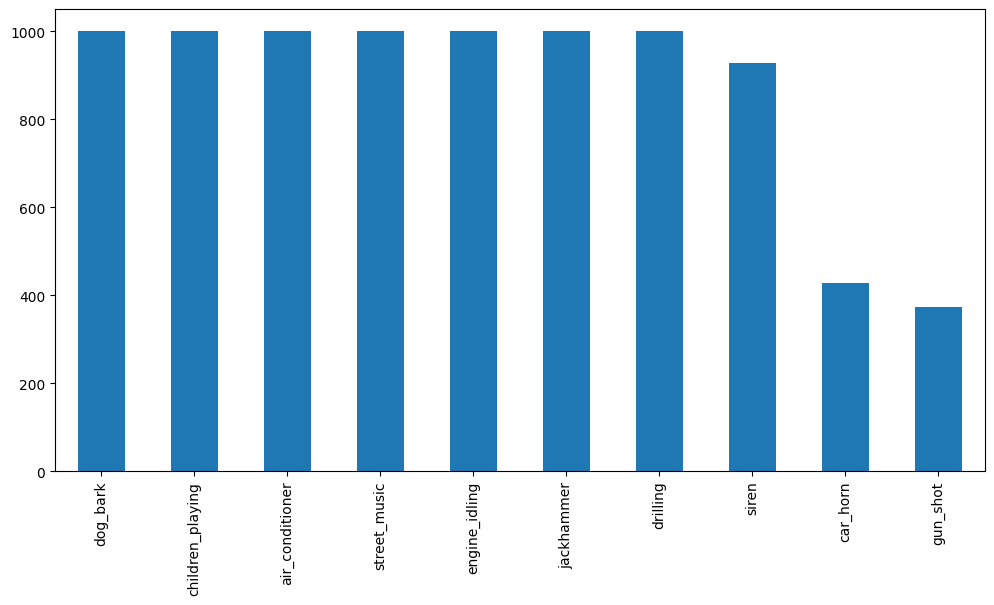

In [13]:
# Class distribution
plt.figure(figsize=(12,6))
metadata["class"].value_counts().plot(kind="bar")
plt.show();

In [14]:
# get a random audio file
index = np.random.randint(0, metadata.shape[0])
file_path = metadata.loc[index, "file_path"]

In [15]:
metadata.loc[index, :]

slice_file_name                                     107842-4-0-2.wav
fsID                                                          107842
start                                                       2.157328
end                                                         6.157328
salience                                                           1
fold                                                               6
classID                                                            4
class                                                       drilling
file_path          /content/drive/MyDrive/UrbanSound8k/data/fold6...
Name: 544, dtype: object

Total samples =  (132300,)
Audio duration =  3.0
samples = [ 0.08993312 -0.18242154 -0.07758532 ... -0.14465787 -0.29473504
 -0.22313496]


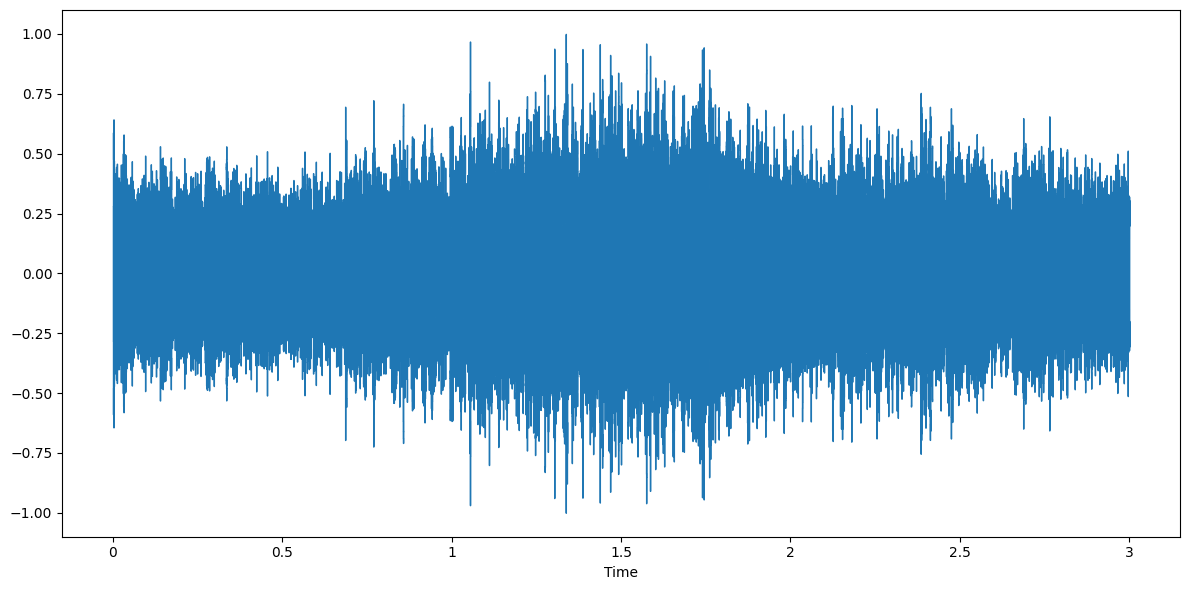

In [18]:
# Load the random audio file and visualize it
signal = load_audio(file_path)
signal = pad_signal(signal)
print("Total samples = ", signal.shape)
print("Audio duration = ", librosa.get_duration(y=signal, sr=Config.sampling_rate))
print("samples =", signal)

plt.figure(figsize=(12,6))
for i in range(signal.ndim):
    if signal.ndim == 1:
        librosa.display.waveshow(signal, sr=Config.sampling_rate)
    else:
        plt.subplot(signal.ndim, 1, i+1)
        librosa.display.waveshow(signal[i, :], sr=Config.sampling_rate)

plt.tight_layout()
plt.show();

In [19]:
ipd.Audio(file_path)

(132300,)


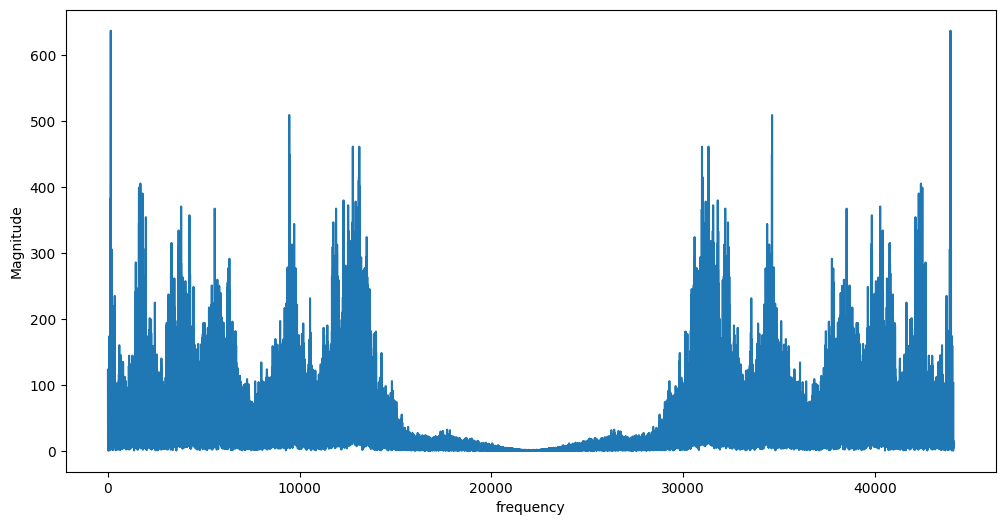

In [20]:
# Fast Fourier transform
fft = np.fft.fft(signal)
print(fft.shape)

magnitudes = np.abs(fft)
frequency_bins = np.linspace(0, Config.sampling_rate, len(magnitudes))

plt.figure(figsize=(12,6))
plt.plot(frequency_bins, magnitudes)
plt.xlabel("frequency")
plt.ylabel("Magnitude")
plt.show();

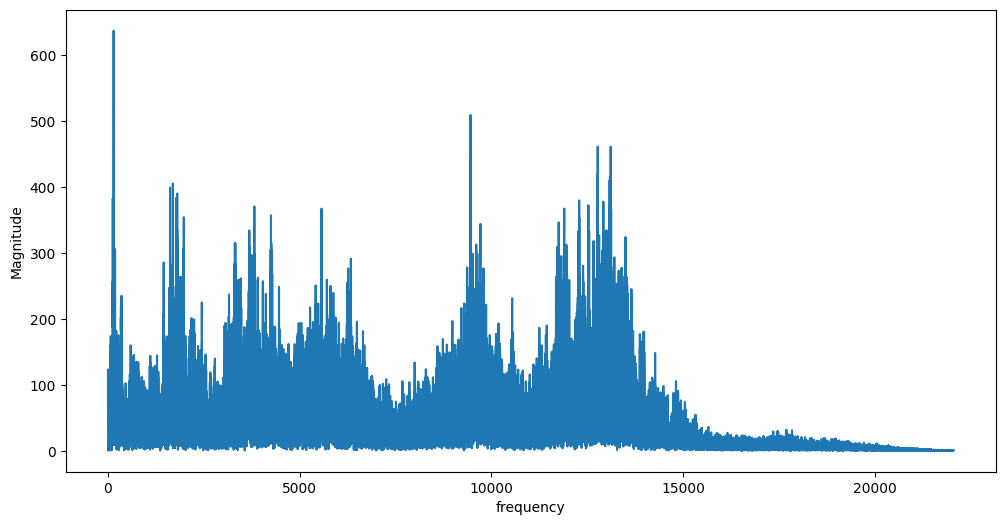

In [21]:
# Since the power spectrum is symmetrical
# Let's zoom in on the left part of the spectrum
left_magnitudes = magnitudes[:int(len(magnitudes)/2)]
left_frequency_bins = frequency_bins[:int(len(magnitudes)/2)]

plt.figure(figsize=(12,6))
plt.plot(left_frequency_bins, left_magnitudes)
plt.xlabel("frequency")
plt.ylabel("Magnitude")
plt.show();

(1025, 259)


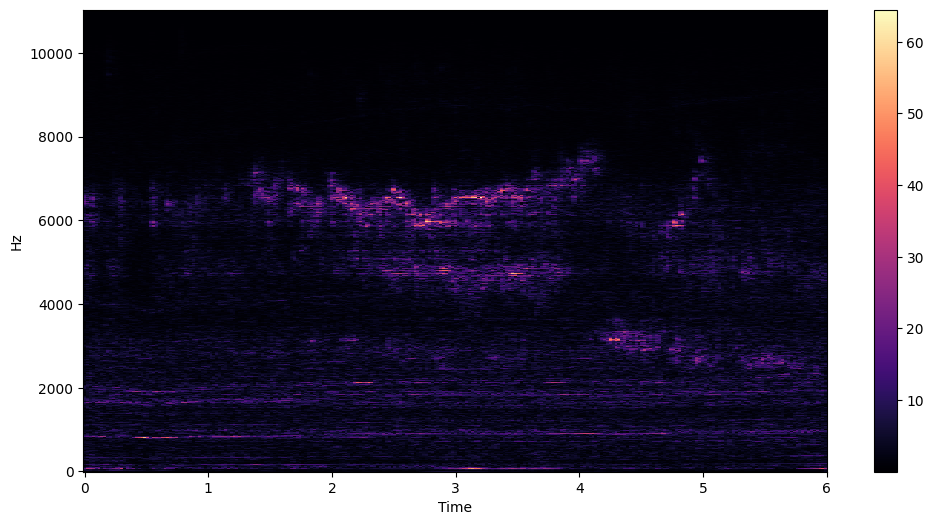

In [22]:
# short time fourier transforms (spectrograms)
stft = librosa.stft(signal, n_fft=Config.n_fft, hop_length=Config.hop_length)
# Get the magnitude part only
spectrogram = np.abs(stft)
print(spectrogram.shape)

plt.figure(figsize=(12,6))
librosa.display.specshow(spectrogram, n_fft=Config.n_fft, hop_length=Config.hop_length, x_axis="time", y_axis="hz")
plt.colorbar()
plt.show();

(1025, 259)


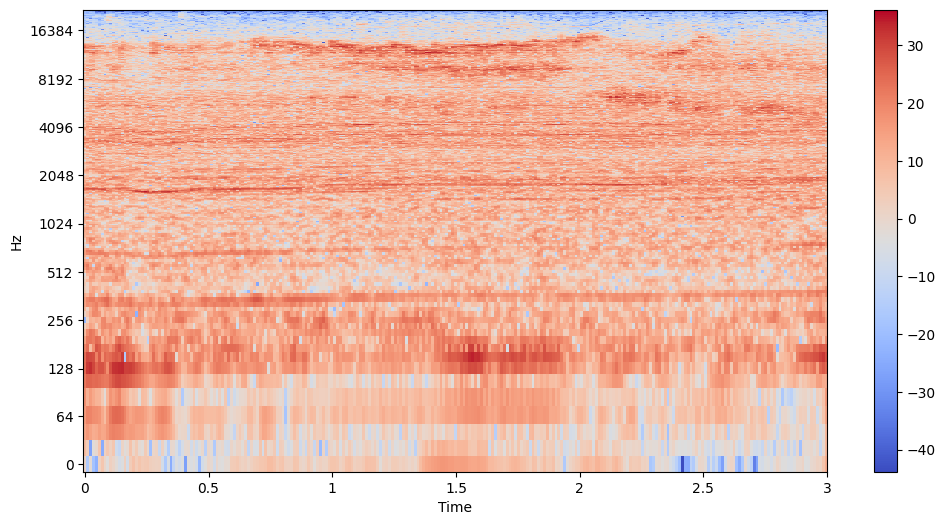

In [23]:
# Taking the spectrogram on log scale
log_spec = librosa.amplitude_to_db(spectrogram)
print(log_spec.shape)

plt.figure(figsize=(12,6))
librosa.display.specshow(log_spec, sr=Config.sampling_rate, n_fft=Config.n_fft, hop_length=Config.hop_length, x_axis="time", y_axis="log")
plt.colorbar()
plt.show();

(28, 259)


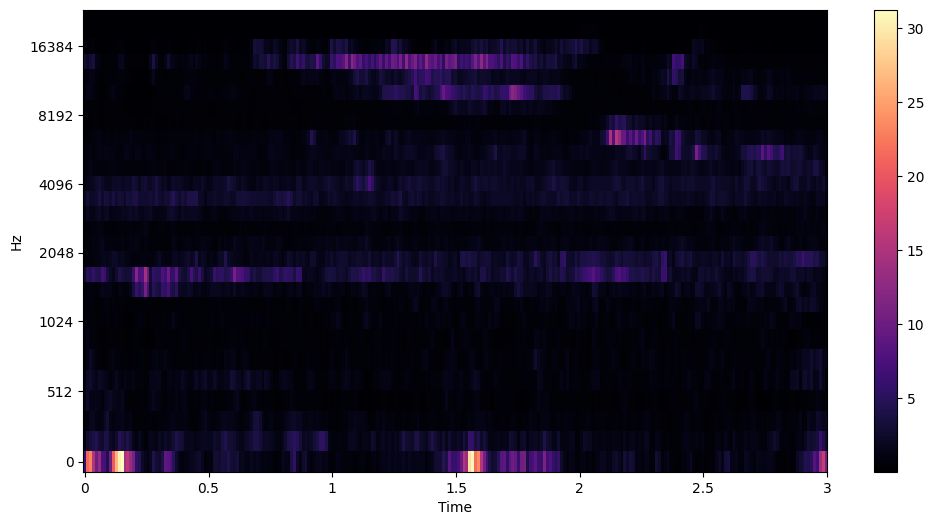

In [24]:
# Mel spectrogram
mel_spec = librosa.feature.melspectrogram(y=signal, sr=Config.sampling_rate, n_fft=Config.n_fft, hop_length=Config.hop_length, n_mels=28)
print(mel_spec.shape)
plt.figure(figsize=(12,6))
librosa.display.specshow(mel_spec, sr=Config.sampling_rate, n_fft=Config.n_fft, hop_length=Config.hop_length, x_axis="time", y_axis="mel")
plt.colorbar()
plt.show();


(50, 259)


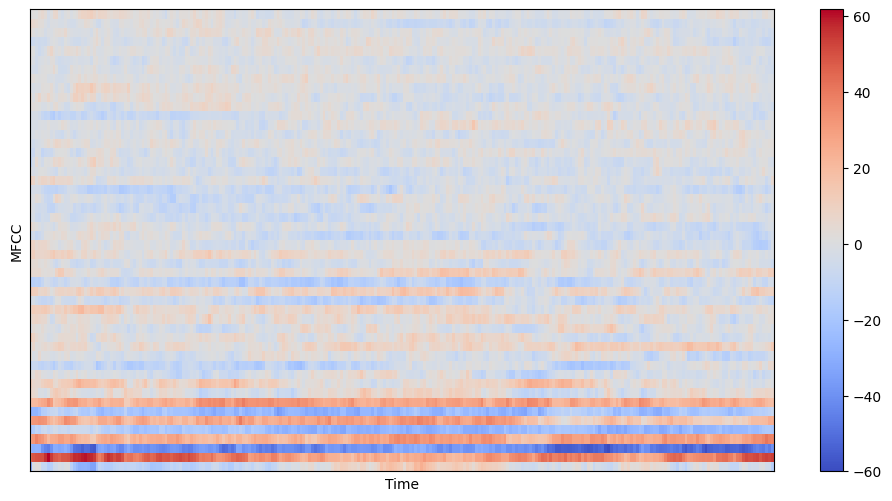

In [25]:
# MFCC features
mfcc = librosa.feature.mfcc(y=signal, n_fft=Config.n_fft, hop_length=Config.hop_length, n_mfcc=Config.n_mfcc)
print(mfcc.shape)
plt.figure(figsize=(12,6))
librosa.display.specshow(mfcc, sr=44100, hop_length=512)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.colorbar()
plt.show();

### Data preparation and preprocessing

In [26]:
df_new = metadata.sample(frac=1)

In [28]:
# Get all the audio files and corresponding labels
wav_files = df_new["file_path"].to_numpy()
class_labels = df_new["classID"].to_numpy()

In [29]:
for i in np.unique(class_labels):
    num_instances = len(np.where(class_labels == i)[0])
    print(f"label = {i}, instances = {num_instances}")

label = 0, instances = 1000
label = 1, instances = 429
label = 2, instances = 1000
label = 3, instances = 1000
label = 4, instances = 1000
label = 5, instances = 1000
label = 6, instances = 374
label = 7, instances = 1000
label = 8, instances = 929
label = 9, instances = 1000


**Create the audio pairs for the model**

In [32]:
# Create audio pairs
X, y = create_audio_pairs(wav_files, class_labels)

In [33]:
X.shape, y.shape

((17464, 2, 50, 50), (17464,))

**Train-Validation-Test split**

In [34]:
# Train-val-test split
X_train, rem_x, y_train, rem_y = train_test_split(X, y, test_size=0.2, stratify=y, random_state=101)
X_val, X_test, y_val, y_test = train_test_split(rem_x, rem_y, test_size=0.25, stratify=rem_y, random_state=201)
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((13971, 2, 50, 50),
 (13971,),
 (2619, 2, 50, 50),
 (2619,),
 (874, 2, 50, 50),
 (874,))

**Feature scaling**

In [35]:
# Get mean and standard deviation from the training set
train_mean = np.mean(X_train, axis=0)
train_std = np.std(X_train, axis=0)

# Apply feature scaling
Xs_train = (X_train - train_mean)/train_std
Xs_val = (X_val - train_mean)/train_std
Xs_test = (X_test - train_mean)/train_std

In [36]:
# Add a third channel to the audio image representations
Xs_train = Xs_train[..., np.newaxis]
Xs_val = Xs_val[..., np.newaxis]
Xs_test = Xs_test[..., np.newaxis]

In [37]:
Xs_train.shape, Xs_val.shape, Xs_test.shape

((13971, 2, 50, 50, 1), (2619, 2, 50, 50, 1), (874, 2, 50, 50, 1))

### Model building and training

We will build a Siamese Neural Network.

A siamese neural network is a neural network architectures that contain two or more identical sub-networks. “Identical” here means they have the same configuration with the same parameters and weights. Parameter updating is mirrored across both sub-networks and it’s used to find similarities between inputs by comparing feature vectors.

**Define the SIAMESE model architecture**

In [38]:
# Base model for the siamese network
def initialize_base_network(name=None):
    dilation_rates = [2**i for i in range(3)]

    input = tf.keras.Input(shape=(50,50,1))
    x = input
    # Dilated convolutions
    for dilation_rate in dilation_rates:
        x = tf.keras.layers.Conv2D(filters=64,
                                    kernel_size=(3,3),
                                    padding='valid',
                                    dilation_rate=(dilation_rate, dilation_rate),
                                    activation='relu',
                                    name="conv2d_dilation_"+str(dilation_rate))(x)

        x = tf.keras.layers.BatchNormalization()(x)


    x = tf.keras.layers.Conv2D(32, 16, padding='same')(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.Activation('tanh')(x)
    x = tf.keras.layers.Flatten()(x)
    out = tf.keras.layers.Dense(128, activation="relu")(x)

    model = tf.keras.Model(inputs=input, outputs=out)
    return model

In [39]:
base_network = initialize_base_network()
base_network.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 50, 50, 1)]       0         
                                                                 
 conv2d_dilation_1 (Conv2D)  (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_dilation_2 (Conv2D)  (None, 44, 44, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 44, 44, 64)       256       
 hNormalization)                                                 
                                                                 
 conv2d_dilation_4 (Conv2D)  (None, 36, 36, 64)        36928 

In [40]:
# Define the two audio inputs
input_a = tf.keras.Input(shape=(50,50,1), name="input_a")
input_b = tf.keras.Input(shape=(50,50,1), name="input_b")

output_a = base_network(input_a)
output_b = base_network(input_b)

x = tf.keras.layers.concatenate([output_a, output_b])
x = tf.keras.layers.Dense(16, activation = 'linear')(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
x = tf.keras.layers.Dense(4, activation="linear")(x)
x = tf.keras.layers.BatchNormalization()(x)
x = tf.keras.layers.Activation("relu")(x)
output = tf.keras.layers.Dense(1, activation="sigmoid")(x)


siamese = tf.keras.Model(inputs=[input_a, input_b], outputs=output)
siamese.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_a (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 input_b (InputLayer)           [(None, 50, 50, 1)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128)          5908256     ['input_a[0][0]',                
                                                                  'input_b[0][0]']                
                                                                                                  
 concatenate (Concatenate)      (None, 256)          0           ['model[0][0]',            

In [ ]:
tf.keras.backend.clear_session()

**Train the model**

* Adam optimizer with learning rate = 0.01
* Early stopping callback to stop model training if there is no improvement after certain epochs.
* Model checkpoint callback to save the best performing state of the model during training.
* Trained for 25 Epochs with a batch size of 64.

In [41]:
EPOCHS = 25
BATCH_SIZE = 64

In [43]:
optim = tf.keras.optimizers.Adam(learning_rate=0.01)
metrics = ["accuracy"]
loss = tf.keras.losses.BinaryCrossentropy()

# callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0,
    patience=5,
    verbose=0,
    mode='auto',
    baseline=None,
    restore_best_weights=False
)

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath="saved_models/urbansound_8k_similarity.hdf5",
    monitor = "val_accuracy",
    verbose=1,
    save_best_only=True
)

#Compile the model
siamese.compile(optimizer=optim, loss=loss, metrics=metrics)

# Train the model
history = siamese.fit([Xs_train[:, 0], Xs_train[:, 1]], y_train.astype("float32"),
                      epochs=EPOCHS, batch_size=BATCH_SIZE, shuffle=True,
                      validation_data=([Xs_val[:,0], Xs_val[:,1]], y_val.astype("float32")),
                      callbacks=[early_stopping, model_checkpoint])

Epoch 1/25
219/219 [==============================] - ETA: 0s - loss: 0.6909 - accuracy: 0.5335
Epoch 1: val_accuracy improved from -inf to 0.53417, saving model to saved_models/urbansound_8k_similarity.hdf5
219/219 [==============================] - 42s 106ms/step - loss: 0.6909 - accuracy: 0.5335 - val_loss: 0.6885 - val_accuracy: 0.5342
Epoch 2/25
218/219 [============================>.] - ETA: 0s - loss: 0.6263 - accuracy: 0.6492
Epoch 2: val_accuracy improved from 0.53417 to 0.61474, saving model to saved_models/urbansound_8k_similarity.hdf5
219/219 [==============================] - 20s 92ms/step - loss: 0.6262 - accuracy: 0.6493 - val_loss: 0.6977 - val_accuracy: 0.6147
Epoch 3/25
218/219 [============================>.] - ETA: 0s - loss: 0.5798 - accuracy: 0.6968
Epoch 3: val_accuracy improved from 0.61474 to 0.68079, saving model to saved_models/urbansound_8k_similarity.hdf5
219/219 [==============================] - 20s 92ms/step - loss: 0.5798 - accuracy: 0.6969 - val_loss: 

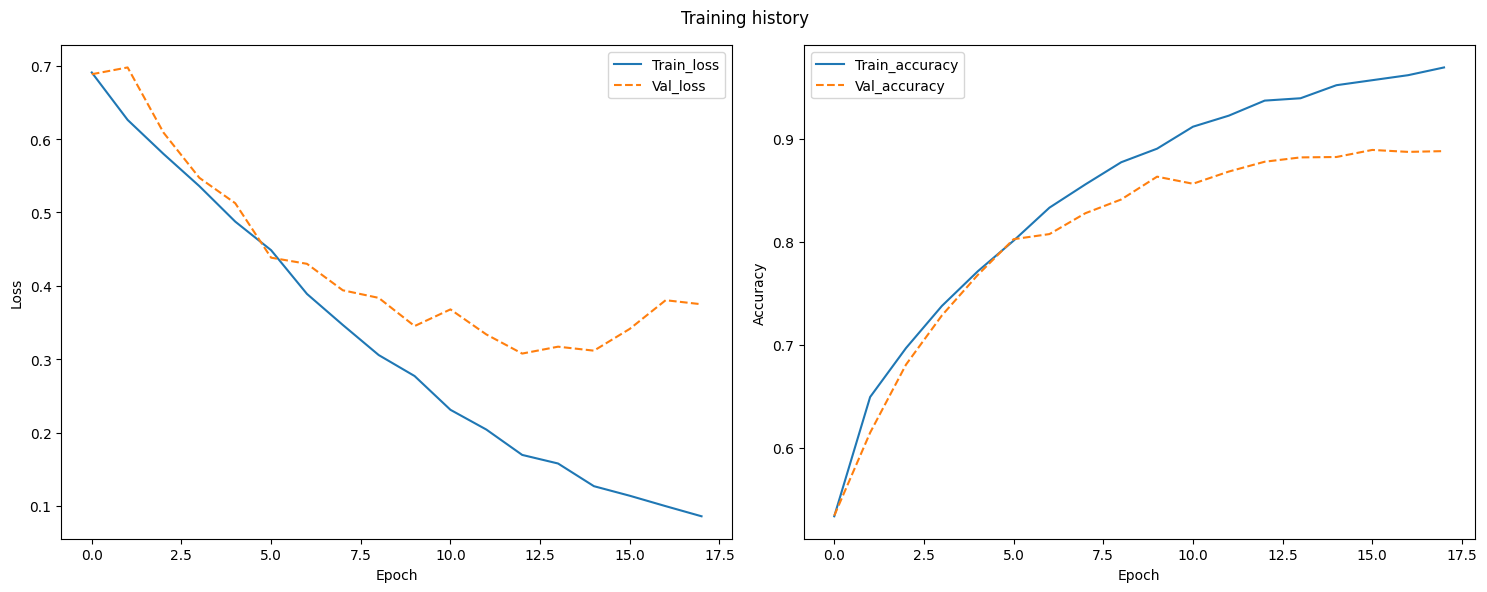

In [49]:
# history of training
plot_learning_curves(history)

### Model evaluation

In [57]:
# Load the model
siamese_saved = tf.keras.models.load_model("saved_models/urbansound_8k_similarity.hdf5")

In [58]:
# Evaluate on test set
los, acc = siamese_saved.evaluate([Xs_test[:,0], Xs_test[:, 1]], y_test)
print("Loss on test set = %.4f" %(los))
print("Accuracy on test set = %.2f %%" %(acc*100))

28/28 [==============================] - 1s 19ms/step - loss: 0.2991 - accuracy: 0.8970
Loss on test set = 0.2991
Accuracy on test set = 89.70 %


In [59]:
# Model predictions on test set
preds = siamese_saved.predict([Xs_test[:,0], Xs_test[:, 1]])
y_preds = np.where(np.squeeze(preds) > 0.5, 1, 0)
y_preds

28/28 [==============================] - 1s 17ms/step


array([1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1,
       0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0,
       1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0,
       1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1,

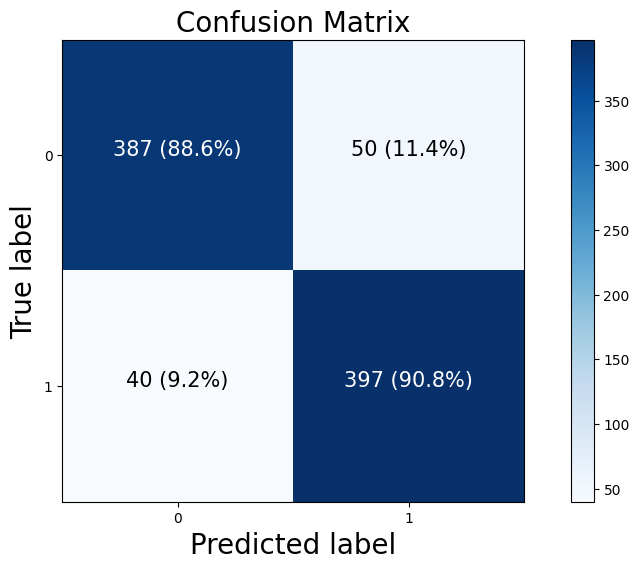

In [60]:
# Plot the confusion matrix
plot_confusion_matrix(y_test, y_preds)

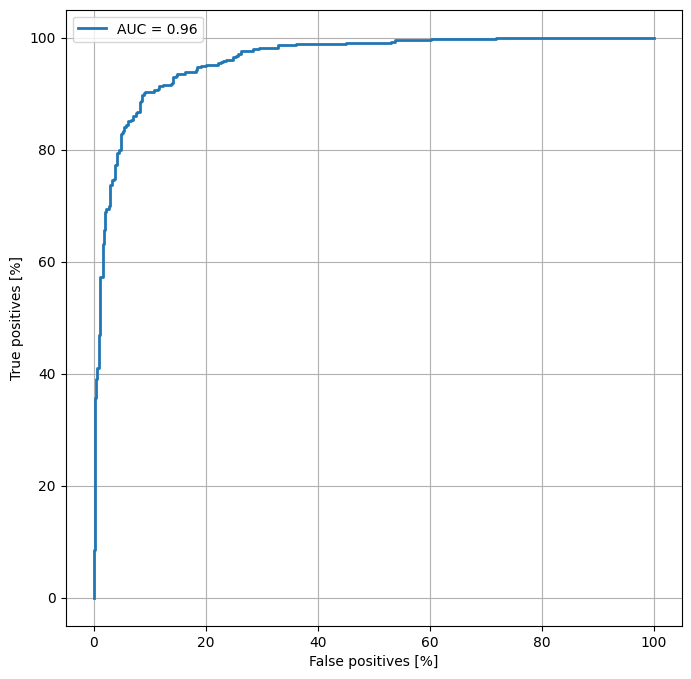

In [61]:
# Receiver operating curve
plot_roc(y_test, preds)